<a href="https://colab.research.google.com/github/Herceg00/sphere_nn/blob/master/Task5/%5B2020_1%5D%20Practice%20task%205%2C%20Speedup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [150]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

In [151]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
from IPython.display import clear_output

def _epoch(network, loss, loader,
           backward=True,
           optimizer=None,
           device='cpu',
           ravel_init=False):
    losses = []
    accuracies = []
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        if ravel_init:
            X = X.view(X.size(0), -1)
        network.zero_grad()
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.cpu().item())
        if backward:
            loss_batch.backward()
            optimizer.step()
        prediction = prediction.max(1)[1]
        accuracies.append((prediction==y).cpu().float().numpy().mean())
    return losses, accuracies


def train(network, train_loader, test_loader,
          epochs, learning_rate, ravel_init=False,
          device='cpu', tolerate_keyboard_interrupt=True):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network = network.to(device)
    try:
        for epoch in range(epochs):
            network.train()
            losses, accuracies = _epoch(network,
                                        loss,
                                        train_loader,
                                        True,
                                        optimizer,
                                        device,
                                        ravel_init)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            network.eval()
            losses, accuracies = _epoch(network,
                                        loss,
                                        test_loader,
                                        False,
                                        optimizer,
                                        device,
                                        ravel_init)

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs


На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [152]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [153]:
images_train, labels_train = next(iter(train_loader))

In [154]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

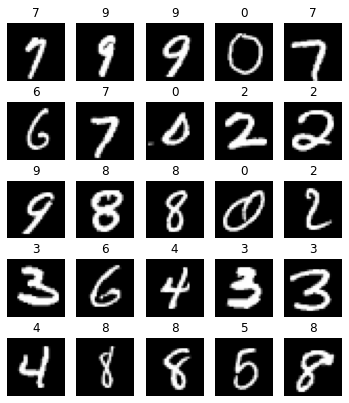

In [155]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [156]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [157]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

# prior to data arrays 
def he_1(size_input, size_output):
    d = 2 / size_input
    return np.sqrt(d)

#prior to gradient arrays
def he_2(size_input, size_output):
    d = 2 / size_output
    return np.sqrt(d)


#init_func = normal
#init_func = xavier
#init_func = good_grad
init_func = he_2
#init_func = he_1

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]
print(layers)

66
[Linear(in_features=784, out_features=64, bias=True), ReLU(), Linear(in_features=64, out_features=32, bias=True), ReLU(), Linear(in_features=32, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [158]:
# Experiments with He_1
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9893643856048584
forward 2.900383949279785
forward 3.779168128967285
forward 5.976131439208984
forward 5.614058017730713
forward 4.188779830932617
forward 4.1600446701049805
forward 3.675644874572754
forward 3.8456826210021973
forward 2.381679058074951
forward 1.5711479187011719
forward 1.5686140060424805
forward 0.9334525465965271
forward 1.024398684501648
forward 0.7276811599731445
forward 0.5939440131187439
forward 0.5211747884750366
forward 0.4581913650035858
forward 0.43171951174736023
forward 0.23797355592250824
forward 0.22016842663288116
forward 0.28858745098114014
forward 0.2078266739845276
forward 0.13045626878738403
forward 0.17069780826568604
forward 0.12500156462192535
forward 0.17233072221279144
forward 0.12567353248596191
forward 0.09319008886814117
forward 0.08455830812454224
forward 0.048992905765771866
forward 0.03251278027892113
forward 0.0291613582521677
backward 0.0221108291298151
backward 0.08630045503377914
backward 0.03987395763397217
backward 0.014554

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [159]:
# Experiments with He_2
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9893643856048584
forward 2.900383949279785
forward 3.779168128967285
forward 5.976131439208984
forward 5.614058017730713
forward 4.188779830932617
forward 4.1600446701049805
forward 3.675644874572754
forward 3.8456826210021973
forward 2.381679058074951
forward 1.5711479187011719
forward 1.5686140060424805
forward 0.9334525465965271
forward 1.024398684501648
forward 0.7276811599731445
forward 0.5939440131187439
forward 0.5211747884750366
forward 0.4581913650035858
forward 0.43171951174736023
forward 0.23797355592250824
forward 0.22016842663288116
forward 0.28858745098114014
forward 0.2078266739845276
forward 0.13045626878738403
forward 0.17069780826568604
forward 0.12500156462192535
forward 0.17233072221279144
forward 0.12567353248596191
forward 0.09319008886814117
forward 0.08455830812454224
forward 0.048992905765771866
forward 0.03251278027892113
forward 0.0291613582521677
backward 0.0221108291298151
backward 0.08630045503377914
backward 0.03987395763397217
backward 0.014554

<i> 1.4 Сделайте выводы по первой части </i>

Как и ожидалось, сеть с активациями ReLU будет хорошо обучаться при "He" инициализации. Лучше показала себя инициализация He_1 - более ровные результаты, если сравнивать forward prop и backward prop. He_2 даст чуть более дальние от 0 градиенты, но дисперсия входов будет больше.


### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [160]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask = mask.bernoulli()
        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [161]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        print("final part: ", final_part)
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

###Clear


In [162]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)   
    layers.append(layer)
    layers.append(nn.ReLU())

del layers[-1]

In [163]:
print(*layers)

Linear(in_features=196, out_features=256, bias=True) ReLU() Linear(in_features=256, out_features=128, bias=True) ReLU() Linear(in_features=128, out_features=10, bias=True)


Epoch 9... (Train/Test) NLL: 0.037/0.058	Accuracy: 0.987/0.982


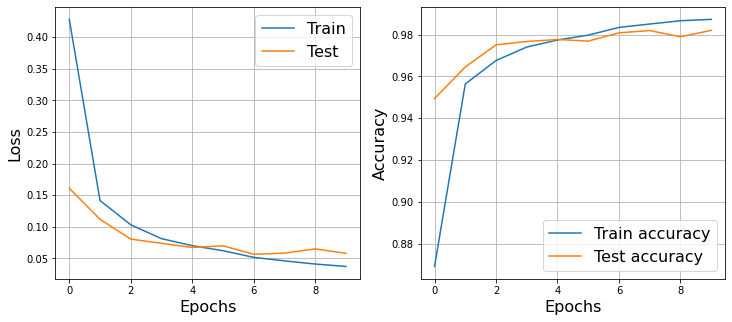

CPU times: user 3min 42s, sys: 3.17 s, total: 3min 45s
Wall time: 3min 45s


In [164]:
%%time


network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Переобучаемся:(

###DropConnect

In [165]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = DropConnect(size_input, size_output, 0.9)
    layers.append(layer)
    layers.append(nn.ReLU())

del layers[-1]

In [166]:
print(*layers)

DropConnect(
  (linear): Linear(in_features=196, out_features=256, bias=True)
) ReLU() DropConnect(
  (linear): Linear(in_features=256, out_features=128, bias=True)
) ReLU() DropConnect(
  (linear): Linear(in_features=128, out_features=10, bias=True)
)


Epoch 9... (Train/Test) NLL: 0.051/0.051	Accuracy: 0.983/0.983


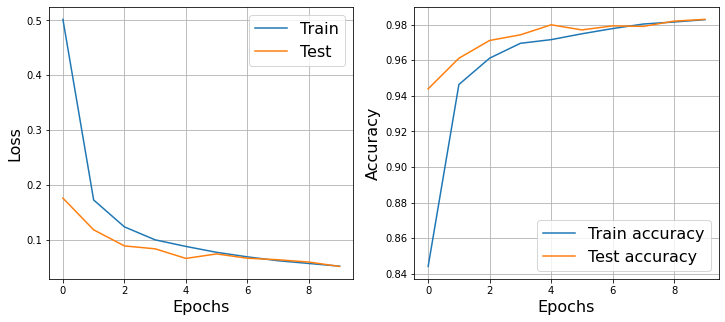

CPU times: user 3min 51s, sys: 3.45 s, total: 3min 55s
Wall time: 3min 55s


In [167]:
%%time

#dropconnect

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Переобучения меньше(появилось только на 8-9 эпохе), точность чуть выше


###DropOut

In [176]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)    
    layers.append(layer)
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(0.5))

del layers[-2:]

In [177]:
print(*layers)

Linear(in_features=196, out_features=256, bias=True) ReLU() Dropout(p=0.5, inplace=False) Linear(in_features=256, out_features=128, bias=True) ReLU() Dropout(p=0.5, inplace=False) Linear(in_features=128, out_features=10, bias=True)


Epoch 9... (Train/Test) NLL: 0.095/0.058	Accuracy: 0.971/0.982


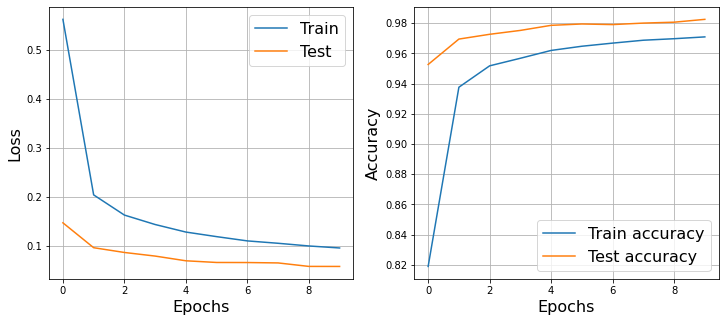

CPU times: user 3min 44s, sys: 3.35 s, total: 3min 47s
Wall time: 3min 47s


In [178]:
%%time

#dropout

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

Dropout продемонстрировал чуть более плохой результат

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [171]:
# полезные функции: .std(dim), .mean(dim)
# "ширина" датасета - всегда последняя размерность, этим и пользуемся
class LayerNormalization(nn.Module):
    def forward(self, x):
        eps=1e-6
        layer_std = x.std(dim=-1,keepdim=True)
        layer_mean = x.mean(dim=-1, keepdim=True)
        output = (x-layer_mean) / (layer_std+eps)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [172]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layers.append(layer)
    layers.append(LayerNormalization())
    layers.append(nn.ReLU())

del layers[-2:]

Epoch 9... (Train/Test) NLL: 0.027/0.045	Accuracy: 0.991/0.986


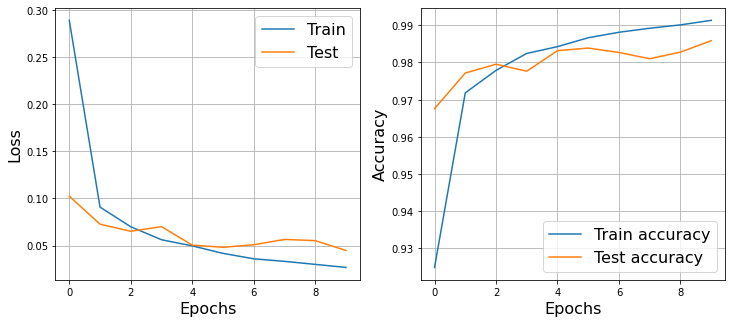

([0.28935463393706756,
  0.09080208681905066,
  0.06992137863405987,
  0.05613299063655105,
  0.0495810913763988,
  0.04164433961154333,
  0.035850438883087275,
  0.03313276158826454,
  0.02993458805323791,
  0.026672444619071572],
 [0.10241243662902072,
  0.0726647351609095,
  0.06512668508376125,
  0.07002917936814454,
  0.050409395129808895,
  0.04811145787575294,
  0.05078245369390337,
  0.05645974784134592,
  0.05517700076975589,
  0.044709677365903235],
 [0.9248401,
  0.97182053,
  0.9778729,
  0.9824372,
  0.9842639,
  0.98665714,
  0.98813415,
  0.98921686,
  0.99012196,
  0.99133795],
 [0.9675633,
  0.97715586,
  0.97952926,
  0.97765034,
  0.9831883,
  0.9838805,
  0.98269385,
  0.98101264,
  0.98279274,
  0.9858584])

In [173]:
network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

In [174]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layers.append(layer)
    layers.append(nn.BatchNorm1d(size_output))
    layers.append(nn.ReLU())

del layers[-2:]

Epoch 9... (Train/Test) NLL: 0.021/0.051	Accuracy: 0.993/0.984


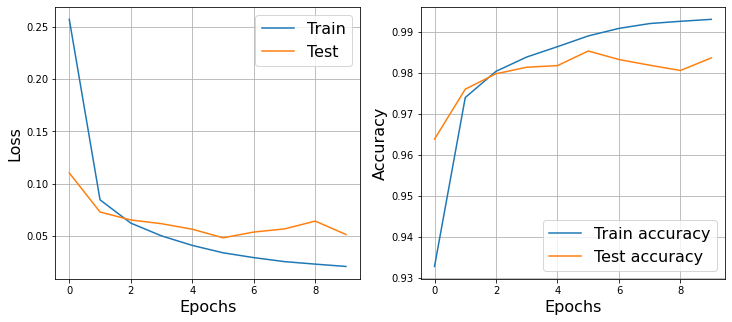

([0.25721612440815356,
  0.08450330810140827,
  0.06223166651173886,
  0.05000278034976233,
  0.04088670804179204,
  0.033818779780821345,
  0.029199349485448937,
  0.02536206772036628,
  0.02296408891741401,
  0.020747031952474893],
 [0.11024636699806285,
  0.07284821542805131,
  0.06524978805616309,
  0.061649604735872415,
  0.05638198739601464,
  0.048161648377065866,
  0.05365131066189607,
  0.0566679207030448,
  0.06414299574975349,
  0.051341701132618184],
 [0.93280804,
  0.9739361,
  0.98032165,
  0.9838031,
  0.9863184,
  0.9889337,
  0.9907716,
  0.9919488,
  0.99249846,
  0.9929704],
 [0.9638054,
  0.97596914,
  0.979727,
  0.98130935,
  0.9817049,
  0.985265,
  0.9831883,
  0.9818038,
  0.9805182,
  0.98358387])

In [175]:
network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>

Переобучение на нормализации высоковато, но скор на тесте от этого не уменьшился

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару:

Немного смутила фраза, что batch norm вычисляется независимо для каждого нейрона. Именно наличие слова "нейрон". Но разобрался.